# A dashboard for exploring MA-XRF data 

In [ ]:
#| default_exp dashboard 

Given our precomputed `.datastack` files present in our Nextcloud storage we can now visualize our MA-XRF data in a Dashboard viewer after downloading them once. 

::: {.callout-warning} 

The total size of these 16 files is pretty big (56.5 GB) and downloading on my computer took about half an hour! 

:::

In [ ]:
#|code-fold: true 
from fairdatanow import DataViewer
import matplotlib.pyplot as plt 
import os
import numpy as np 

In [ ]:
#|code-fold: true 
configuration = {
    'url': "https://laboppad.nl/falnama-project", 
    'user':    os.getenv('NC_AUTH_USER'),
    'password': os.getenv('NC_AUTH_PASS')
}

In [ ]:
filters = {'extensions': ['.datastack']} 

dv = DataViewer(configuration, **filters)
datastack_files = dv.download_filtered() 

Ready with downloading 16 selected remote files to local cache: /home/frank/.cache/fairdatanow                                                                      


Ok, let's start our exploration by plotting a thumbnail overview of all scanned areas. 

In [ ]:
import maxrf4u as mx
import matplotlib.pyplot as plt
import re
from falnama import plot_roi_dashboard, get_roi_ims
from matplotlib.patches import Rectangle

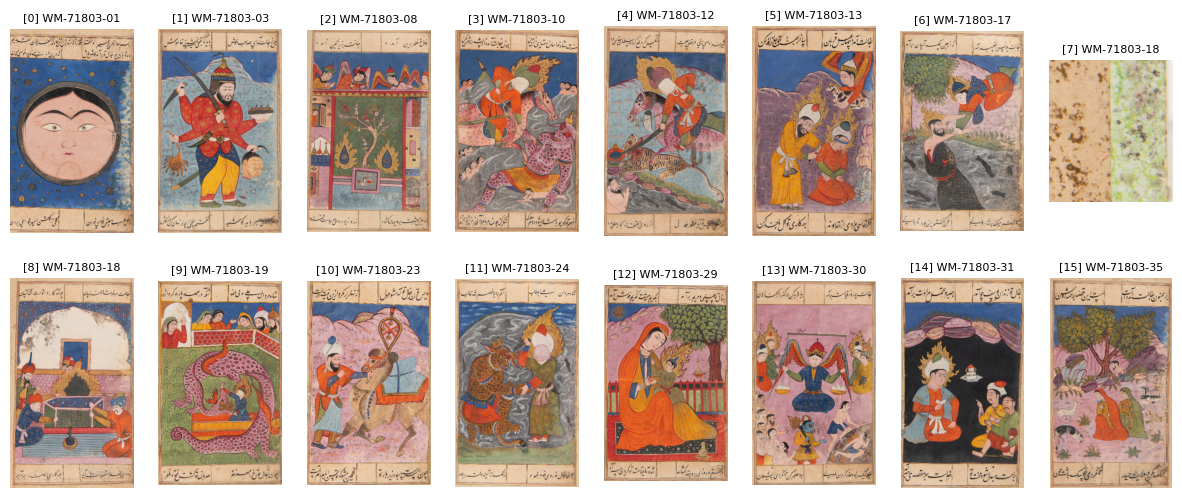

In [ ]:
imvis_list = []
extent_list = []
for datastack_file in datastack_files: 
    ds = mx.DataStack(datastack_file)
    im = ds.read('imvis_reg')
    extent = ds.read('imvis_extent')
    imvis_list.append(im)
    extent_list.append(extent)

object_nums = [re.sub(r'.*(WM-71803-\d\d).*', r'\1', dsf) for dsf in datastack_files]

fig, axs = plt.subplots(ncols=8, nrows=2, figsize=[15, 6])
axs = axs.flatten()
for i, [im, ax, extent] in enumerate(zip(imvis_list, axs, extent_list)): 
    ax.imshow(im, extent=extent)
    ax.set_title(f'[{i}] {object_nums[i]}', fontsize=8)
    ax.axis('off')

## ROI tabs Dashboard 

So far my latest dashboard code made for the MuseumNext conference is not very interactive at all, but would seem to approach a layout that seems ok. We need to adapt a lot of things still...

A first step now is to manually select regions of interest for page 35 (index 15)...

In [ ]:
n = 15
datastack_file = datastack_files[n]
ds = mx.DataStack(datastack_file)

object_num = object_nums[n]

#cube = ds.read('maxrf_cube', compute=False)
imvis_highres = ds.read('imvis_reg_highres')
#imvis = ds.read('imvis_reg')
extent = ds.read('imvis_extent')
#x_keVs = ds.read('maxrf_energies')
#y_maxspectrum = ds.read('maxrf_maxspectrum')

#nmf_elementmaps = ds.read('nmf_elementmaps') 

#ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file, tube_keV=23)

#ds.tree()

In [ ]:
%matplotlib widget

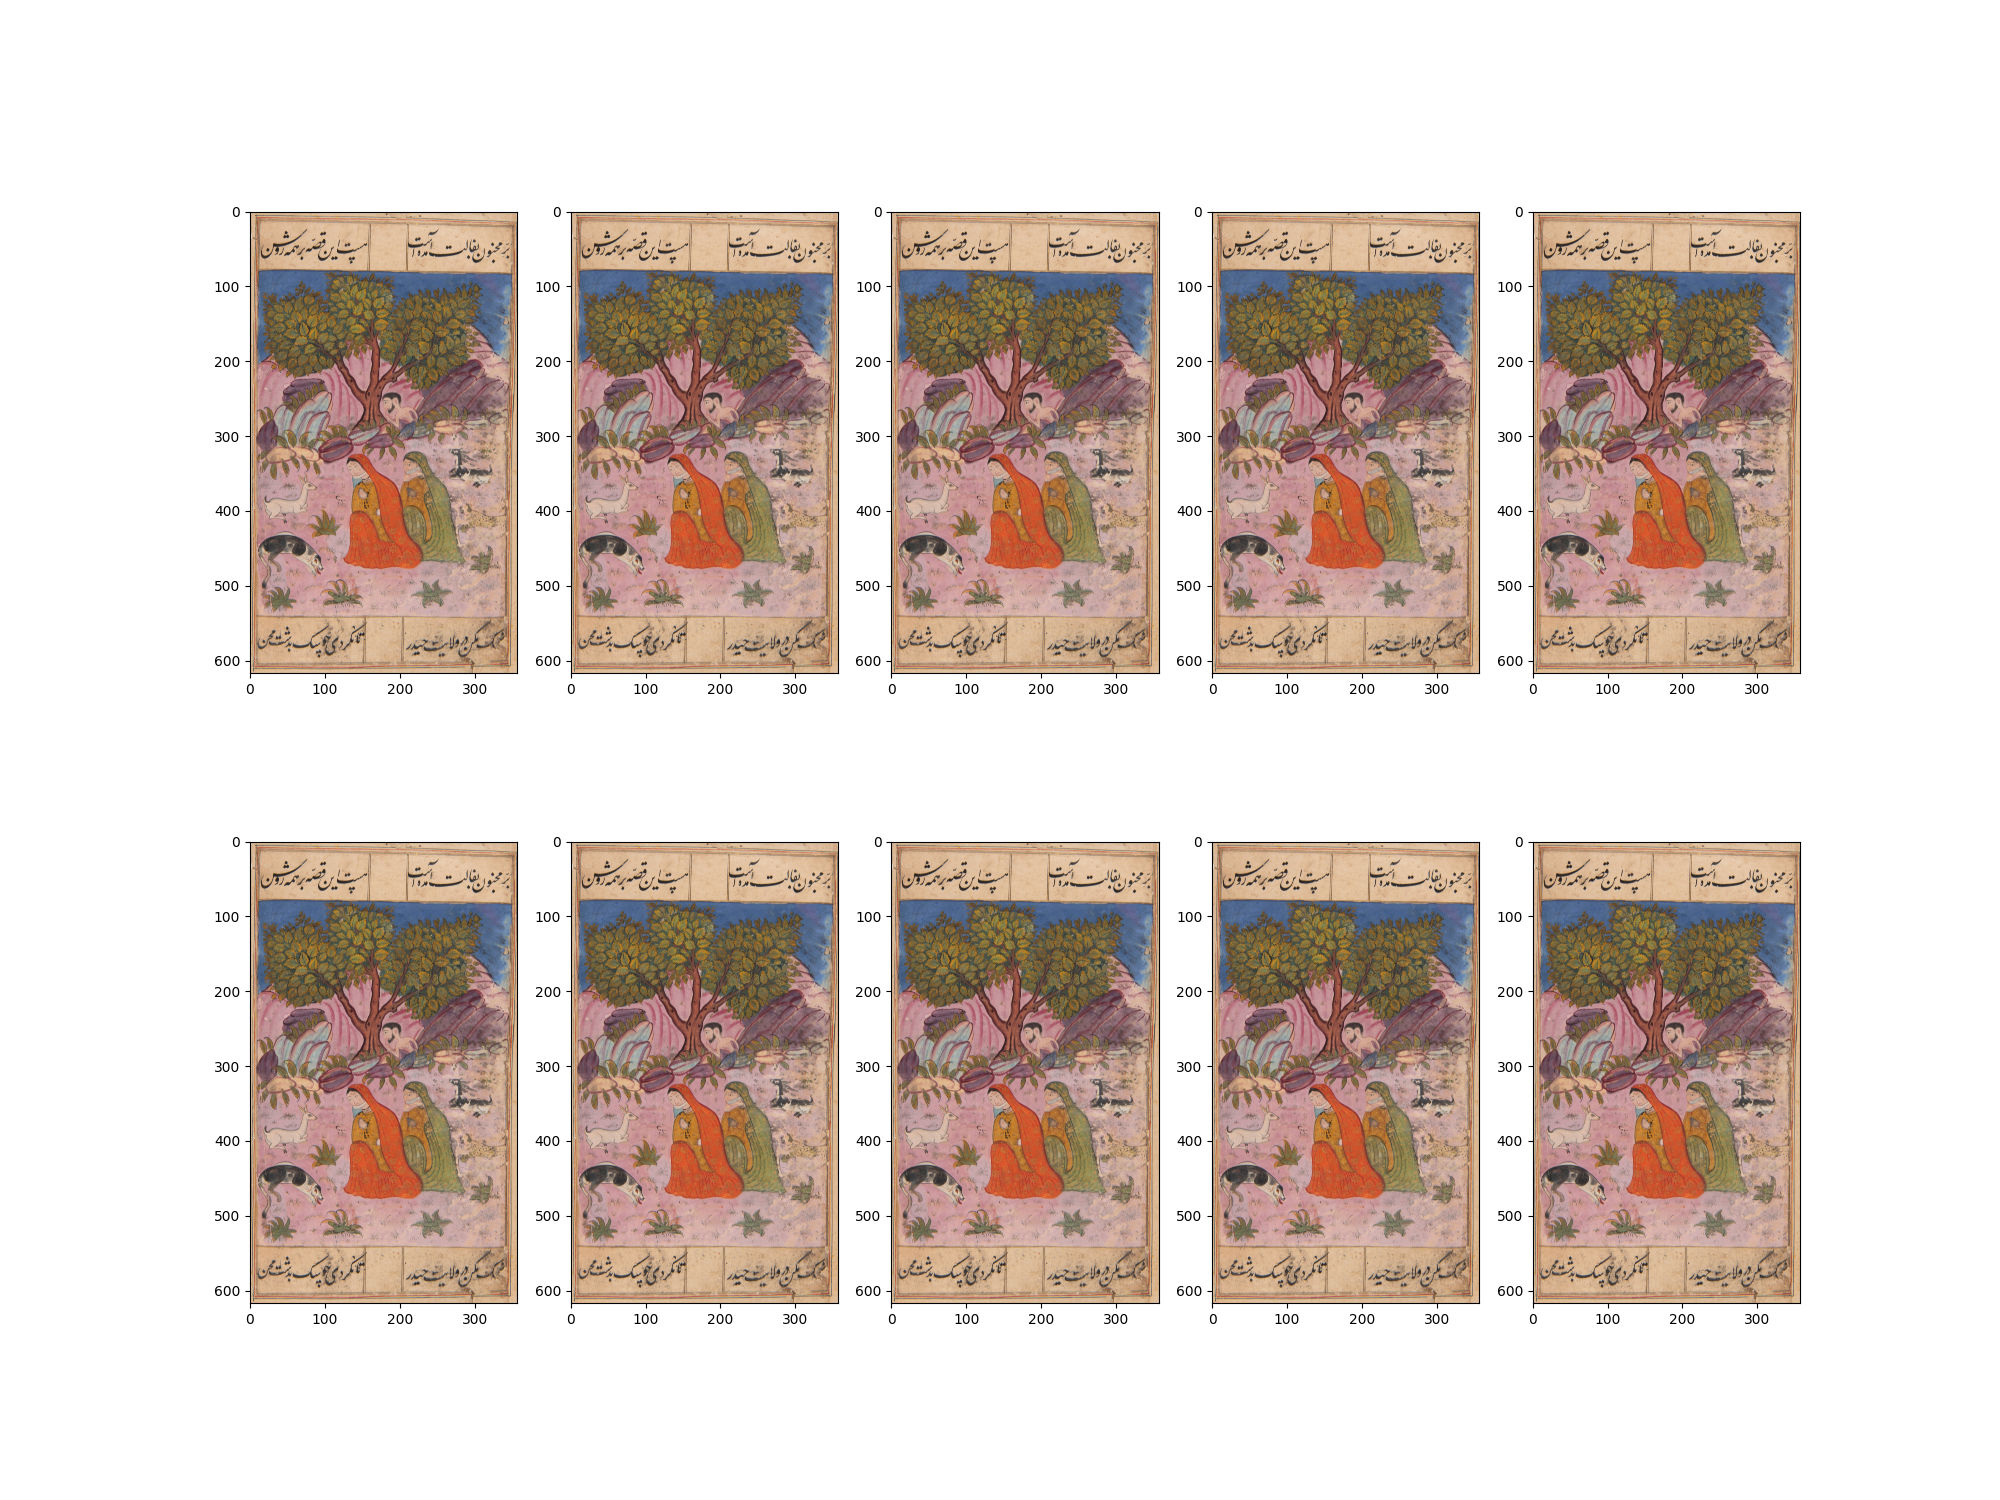

In [ ]:
#|hide 

# uncomment and run this cell to create regions of interest
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=[20, 15])
axs = axs.flatten()
for ax in axs: 
    ax.imshow(imvis_highres, extent=extent)


In [ ]:
xylims_list = [[int(ax.get_xlim()[0]), int(ax.get_xlim()[1]), int(ax.get_ylim()[0]), int(ax.get_ylim()[1])] for ax in axs]

[[29, 51, 106, 84],
 [39, 88, 136, 91],
 [154, 183, 242, 208],
 [275, 296, 249, 227],
 [40, 59, 289, 269],
 [72, 124, 441, 397],
 [146, 168, 462, 443],
 [139, 161, 393, 370],
 [245, 268, 454, 433],
 [197, 219, 300, 278]]

In [ ]:
xylims_list = [[29, 51, 106, 84], [39, 88, 136, 91], [154, 183, 242, 208], [275, 296, 249, 227], [40, 59, 289, 269],
               [72, 124, 441, 397], [146, 168, 462, 443], [139, 161, 393, 370], [245, 268, 454, 433], [197, 219, 300, 278]]

roi_ims = get_roi_ims(datastack_file, xylims_list)

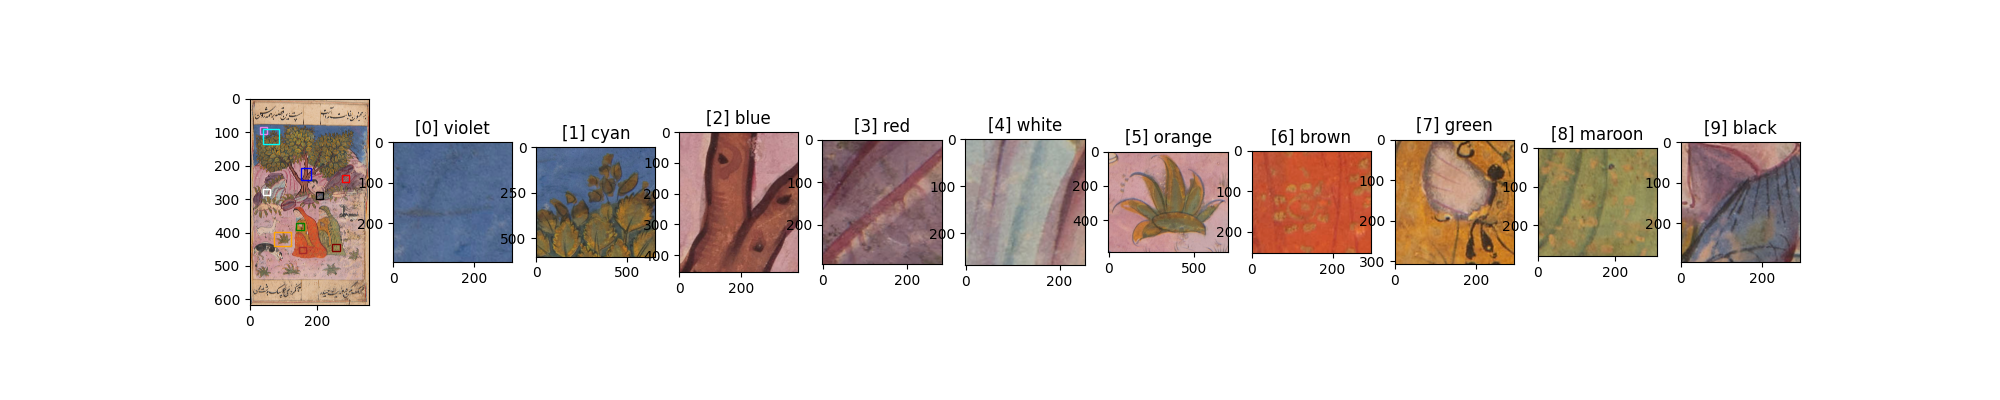

In [ ]:
fig, axs = plt.subplots(ncols=len(roi_ims)+1, figsize=[20, 4], squeeze=True)

edgecolors = ['violet', 'cyan', 'blue', 'red', 'white', 'orange', 'brown', 'green', 'maroon', 'black']

axs[0].imshow(imvis_highres, extent=extent)

for i, xylims in enumerate(xylims_list):
    x0, x1, y0, y1 = xylims
    axs[0].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))

for i, [ax, im] in enumerate(zip(axs[1:], roi_ims)): 
    
    ax.imshow(im)
    ax.set_title(f'[{i}] {edgecolors[i]}')

Here is the latest still very rough code for an ROI tabs dashboard. 

In [ ]:
roi_elements_list = [['Pb', 'K', 'Ca', 'Fe'], #0 We see a clear 
                     ['Pb', 'K', 'Ca', 'As', 'S'], #1
                     ['Pb', 'Fe', 'Ca', 'Hg'], #2
                     ['Pb'], #3
                     ['Pb', 'Fe', 'Ca'], #4
                     ['Pb', 'As', 'S', 'Fe'], #5 Here we see that the NMF maps are more clear the the alpha slices
                     ['Au', 'Pb', 'As'], #6 Clearly gold on red lead. The Pb alpha slice map is confusing   
                     ['Pb', 'As', 'S', 'Au'], #7 The yellow robe is clearly orpiment. Here again the the overlapping Pb alpha with As is confusing 
                     ['As', 'S', 'Au', 'Pb'], #8 According to the NMF map there should be no lead present in the green robe 
                     ['Pb']] #9

In [ ]:
plot_roi_dashboard(datastack_file, xylims_list, roi_elements_list) 

Please wait while initializing peak pattern atlas...
                                                  


In [ ]:
plt.close('all')

## FUNCTIONS 

In [ ]:
#|export 

import falnama as fn
import matplotlib.pyplot as plt
import maxrf4u as mx  
import moseley as mos
import numpy as np
import scipy.signal as ssg 
import matplotlib.cm as cm
import skimage.exposure as ske
from matplotlib.patches import Rectangle
import re
from ipywidgets import widgets 

In [ ]:
#|export 

elem_colors = {'Pb': 'k', 'Au': 'orange', 'Fe': 'brown', 'Ca': 'g', 'K': 'b', 'As': 'magenta', 'Na': 'blue', 'Ni': 'red', 'Cu': 'green', 'Ti': 'blue', 'Zn': 'red'}

def plot_roi_peak_patterns(roi_cube, prominence=2, ax=None): 
    '''Plot patterns of the roi cube hotmax spectra.'''

    hotmax_idxs, spectra = get_hotmax_spectra(roi_cube)
    
    peak_idxs_list = []
    for y in spectra: 
        peak_idxs = ssg.find_peaks(y, prominence=2)[0] 
        peak_idxs_list.append(peak_idxs)

    if ax is None: 
        fig, ax = plt.subplots()

    for i, peak_idxs in enumerate(peak_idxs_list): 
        
        peak_idxs = peak_idxs[1:] # get rid of instrument peak at zero

        ones = np.ones_like(peak_idxs)

        ax.scatter(x_keVs[peak_idxs], (len(peak_idxs_list) - i) * ones)
        ax.plot(x_keVs[peak_idxs], (len(peak_idxs_list) - i) * ones)
        
    return peak_idxs_list 

def get_hotmax_spectra(roi_cube): 
    '''Get hotmax spectra for `roi_cube`. 
    
    Returns: `hotspot_idxs, `spectra` 
    '''

    hotmax_idxs = []
    spectra = []
    
    n_channels = roi_cube.shape[-1]
    y_max = roi_cube.reshape([-1, n_channels]).max(axis=0) 
    peak_idxs = ssg.find_peaks(y_max, prominence=1)[0] 
    
    
    for p_i in peak_idxs: 
        peak_slice = roi_cube[:,:, p_i]
        i, j = np.argwhere(peak_slice == peak_slice.max())[0]
   
        y = roi_cube[i, j]
        
        spectra.append(y)
        hotmax_idxs.append([int(i), int(j), int(p_i)])

    hotmax_idxs = np.array(hotmax_idxs)

    return hotmax_idxs, spectra 


def plot_hotmax_spectra(spectra, x_keVs, hotmax_idxs, elems=None, xlim=[-1, 22], elem_colors=elem_colors, y_maxspectrum=None):
    '''Plot roi hotmax spectra and add emission lines for list of elements `elems`. 

    Returns: axs 
    '''

    peak_idxs = hotmax_idxs[:, 2] 
    
    fig, axs = plt.subplots(nrows=len(spectra), sharex=True, sharey=True, figsize=[20, 20], squeeze=True, layout='compressed')
    
    for i, y in enumerate(spectra): 
        axs[i].set_xlim(xlim)
        if y_maxspectrum is not None: 
            axs[i].plot(x_keVs, y_maxspectrum, color='r', alpha=0.1)
        axs[i].plot(x_keVs, y, label=f'#{i}')
        axs[i].scatter(x_keVs[peak_idxs[i]], y[peak_idxs[i]], marker='s', color='r')
        axs[i].legend()
    
        if elems is not None: 
            for elem in elems: 
            
                plot_element_lines(elem, y=y, ax=axs[i], x_keVs=x_keVs, color=elem_colors[elem])

    return axs    

def get_element_lines(element, x_keVs, exc_keV=23): 
    '''Get sorted element peak idxs. '''
    
    elem_y = mx.get_element_spectrum(element, exc_keV, x_keVs=x_keVs)
    peak_idxs = ssg.find_peaks(elem_y)[0]
    peak_idxs = np.array([int(idx) for idx in peak_idxs])
    peaks_x = x_keVs[peak_idxs]
    peaks_y = elem_y[peak_idxs] 

    sort_idxs = np.argsort(peaks_y)
    peak_idxs_sorted = peak_idxs[sort_idxs][::-1] 

    return peak_idxs_sorted

    
def plot_element_lines(element, x_keVs, y=None, ax=None, exc_keV=23, color=None): 
    '''Add emission lines to spectral plot. '''

    if ax == None: 
        fig, ax = plt.subplots(figsize=[15, 5])
        
    if color is None: 
        color = mx.colorize(element)
    
    elem_y = mx.get_element_spectrum(element, exc_keV, x_keVs=x_keVs)
    peak_idxs = ssg.find_peaks(elem_y)[0]
    #peak_idxs = np.array([int(idx) for idx in peak_idxs])
    peaks_x = x_keVs[peak_idxs]
    peaks_y = elem_y[peak_idxs] 

    sort_idxs = np.argsort(peaks_y)

    peak_idxs_sorted = get_element_lines(element, x_keVs)
    
    # normalize peaks 
    if y is not None: 
        norm_idx = peak_idxs_sorted[0]
        y_norm  = y[norm_idx]
        peaks_y = peaks_y * y_norm
    
    ax.vlines(peaks_x, np.zeros_like(peaks_y), peaks_y, color=color)
    ax.scatter(peaks_x, peaks_y, marker='s', facecolor=color, edgecolor='k')
    
    for x, y in zip(peaks_x, peaks_y): 
        ax.annotate(element, [x-0.1, y + 2], color='k') 

    return peak_idxs_sorted 

def get_roi_maps(roi_cube, elements, x_keVs, exc_keV=23): 
    '''Slice `roi cube` at alpha index positions for each element in `elements`. 
    
    Returns: alpha_idxs, roi_maps
    '''

    roi_maps = []
    alpha_idxs = []
    

    for elem in elements: 

        sorted_peak_idxs = get_element_lines(elem, x_keVs, exc_keV)
        alpha_idx = sorted_peak_idxs[0]
        roi_map = roi_cube[:,:,alpha_idx]
        roi_maps.append(roi_map)
        alpha_idxs.append(int(alpha_idx))

    return alpha_idxs, roi_maps
    

def plot_roi_maps(roi_cubes, xylims_list, roi_n, elements, y_maxspectrum=None, exc_keV=23): 
    '''Plot roi alpha maps for list of `elements`. 
    
    If `y_maxspectrum` is specified normalize with maximum at channel index.'''

    alpha_idxs, roi_maps = get_roi_maps(roi_cubes[roi_n], elements, x_keVs, exc_keV=exc_keV)

    fig, axs = plt.subplots(ncols=len(elements) + 1, squeeze=True, figsize=[20, 10])
    
    axs[0].imshow(imvis_highres, extent=extent)
    axs[0].set_xlim(xylims_list[roi_n][0:2])
    axs[0].set_ylim(xylims_list[roi_n][2:4])
    axs[0].set_title(f'roi #{roi_n}')
    
    for ax, roi_map, elem, alpha_idx in zip(axs[1:], roi_maps, elements, alpha_idxs): 
        if y_maxspectrum is not None: 
            vmax = y_maxspectrum[alpha_idx]
        else: 
            vmax = None 
        ax.imshow(roi_map, vmin=0, vmax=vmax)
        ax.set_title(elem)


def get_nmf_map(datastack_file, element): 
    '''Read computed NMF element map for `element` from `datastack`.'''

    ds = mx.DataStack(datastack_file)

    elem_idx = mx.elems_from_atomnums(ds.nmf_atomnums.compute()).index(element)
    nmf_elementmaps = ds.read('nmf_elementmaps') 
    nmf_map = nmf_elementmaps[elem_idx] 

    return nmf_map

def pick_nmf_elementmap(datastack_file, nmf_elementmaps, element): 
    '''Faster get nmf element map'''

    ds = mx.DataStack(datastack_file) 

    elem_idx = mx.elems_from_atomnums(ds.nmf_atomnums.compute()).index(element)
    nmf_map = nmf_elementmaps[elem_idx] 

    return nmf_map 


def get_slice_map(datastack_file, element, peak_idx=0): 
    '''Compute simple single channel map from `datastack_file` cube for `element` alpha channel.

    Choose option `peak_idx=1` for beta peak.  
    
    Returns: element map '''

    ds = mx.DataStack(datastack_file)
    x_keVs = ds. read('maxrf_energies')
    cube = ds.read('maxrf_cube', compute=False) 
    
    line_idxs = get_element_lines(element, x_keVs)
    alpha_idx = line_idxs[peak_idx]

    alpha_arr = cube[:,:, alpha_idx]
    alpha_map = alpha_arr.compute()

    return alpha_map 
    

def get_roi_ims(datastack_file, xylims_list): 
    '''Get high resolution roi images for `xylims_list`.'''

    ds = mx.DataStack(datastack_file)
    
    # read images 
    imvis_highres = ds.read('imvis_reg_highres')
    imvis = ds.read('imvis_reg')

    # compute scale factors 
    highres_h, highres_w, _ = imvis_highres.shape 
    h, w, _ = imvis.shape  
    y_factor = highres_h / h
    x_factor = highres_w / w

    # get roi images 
    roi_ims = []
    for xylims in xylims_list: 
        i, j, k, l = map(int, np.array(xylims) * np.array([x_factor, x_factor, y_factor, y_factor]))
        roi_im = imvis_highres[l:k,i:j] 
        roi_ims.append(roi_im)

    return roi_ims


def plot_roi_peak_patterns(roi_cube, prominence=2, ax=None): 

    hotmax_idxs, spectra = get_hotmax_spectra(roi_cube)
    
    peak_idxs_list = []
    for y in spectra: 
        peak_idxs = ssg.find_peaks(y, prominence=2)[0] 
        peak_idxs_list.append(peak_idxs)

    if ax is None: 
        fig, ax = plt.subplots()

    for i, peak_idxs in enumerate(peak_idxs_list): 
        
        peak_idxs = peak_idxs[1:] # get rid of instrument peak at zero

        ones = np.ones_like(peak_idxs)

        ax.scatter(x_keVs[peak_idxs], i * ones)
        ax.plot(x_keVs[peak_idxs], i * ones)
        
    return peak_idxs_list 


# roi_cubes, roi_ims, roi_elements_list, nmf_elementmaps, x_keVs, imvis_highres, extent, object_num, xylims_list

def plot_roi_dashboard(datastack_file, xylims_list, roi_elements_list): #, roi_cubes, roi_ims, , nmf_elementmaps, x_keVs, imvis_highres, extent, object_num, xylims_list): 
    '''Create tabbed plot for roi spectra. '''

    
    # initialize variables 
    # datastack only 
    edgecolors = ['violet', 'cyan', 'blue', 'red', 'white', 'orange', 'brown', 'green', 'maroon', 'black']

    ds = mx.DataStack(datastack_file)
    
    object_num = re.sub(r'.*(WM-71803-\d\d).*', r'\1', datastack_file) 
    
    cube = ds.read('maxrf_cube', compute=False)
    imvis_highres = ds.read('imvis_reg_highres')
    imvis = ds.read('imvis_reg')
    extent = ds.read('imvis_extent')
    x_keVs = ds.read('maxrf_energies')
    y_maxspectrum = ds.read('maxrf_maxspectrum')
    
    nmf_elementmaps = ds.read('nmf_elementmaps') 

    ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file, tube_keV=23)
    
    # ROI specific 
    roi_cubes = [cube[l:k, i:j].compute() for i, j, k, l in xylims_list] 
    roi_ims = get_roi_ims(datastack_file, xylims_list)
    
    # initialize tabs 
    sub_tab=[widgets.Output() for i in range(len(roi_cubes))]
    tab = widgets.Tab(sub_tab)
    for roi_n in range(len(roi_cubes)):
        tab.set_title(roi_n, f'ROI [{roi_n}]')
        print(f'Rendering dashboard tab for ROI {roi_n}/{len(roi_cubes) -1}...', end='\r') 
    
        with sub_tab[roi_n]: 
       
            # roi cube (core) maxspectrum 
            hotmax_idxs, spectra = get_hotmax_spectra(roi_cubes[roi_n])
            roi_cube = roi_cubes[roi_n]
            roi_h, roi_w, roi_d = roi_cube.shape
            roi_flat = roi_cube.reshape([-1, roi_d])
            roi_maxspectrum = roi_flat.max(axis=0) # actually this is the roi core max spectrum  

            roi_elements = roi_elements_list[roi_n]
            
            # create sub figures and their axes 
            fig = plt.figure(layout='constrained', figsize=(15, 7))
            subfigs = fig.subfigures(ncols=2, wspace=0.07, width_ratios=[2, 1], squeeze=True) #

            # left top and bottom figures
            leftfigs = subfigs[0].subfigures(nrows=2, wspace=0.07, height_ratios=[1, 2]) 
            topleft_axs = leftfigs[0].subplots(ncols=len(roi_elements) + 1, squeeze=True) # ncols actually depends on number of elements 
            botleft_axs = leftfigs[1].subplots(ncols=len(roi_elements) + 1, squeeze=True, sharex=True, sharey=True) # same  

            # create spectral axes for right figure,
            axs_right = subfigs[1].subplots(nrows=2, squeeze=True, sharex=True) 
            
            # PLOTS 
            
            # plot roi RGB image in top left figure  
            topleft_axs[0].imshow(roi_ims[roi_n], extent=[0, roi_w, roi_h, 0]) 
            topleft_axs[0].set_title(f'ROI [{roi_n}]')
            
            topleft_axs[0].add_patch(Rectangle([0, 0], roi_w, roi_h, linewidth=5, edgecolor=edgecolors[roi_n], facecolor='none'))
 
            yi, xi = hotmax_idxs[:, 0:2].T
            topleft_axs[0].scatter(xi, yi, color='w', marker='+') 

            # plot roi element maps in top left figure  
            alpha_idxs, roi_maps = get_roi_maps(roi_cube, roi_elements, x_keVs, exc_keV=23)
            
            for ax, im, element in zip(topleft_axs[1:], roi_maps, roi_elements): 
                ax.imshow(im, vmin=0)
                ax.set_title(f'{element} (slice)')
                      
            
            # plot overview RGB image in bottom left figure  
            botleft_axs[0].imshow(imvis_highres, extent=extent)
            botleft_axs[0].set_title(object_num)
            for i, xylims in enumerate(xylims_list):
                x0, x1, y0, y1 = xylims
                botleft_axs[0].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))
                botleft_axs[0].annotate(f'ROI {i}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=8)

            # plot full NMF element maps in bottom left figure 
            for ax, element in zip(botleft_axs[1:], roi_elements): 
                nmf_map = pick_nmf_elementmap(datastack_file, nmf_elementmaps, element) # global!!
                
                ax.imshow(nmf_map, vmin=0)
                ax.set_title(f'{element} (NMF)')
                for i, xylims in enumerate(xylims_list):
                    x0, x1, y0, y1 = xylims
                    ax.add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))
                    ax.annotate(f'ROI {i}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=8)
            
            # plot roi patterns (for now let's not plot this)
            #peak_idxs_list = plot_roi_peak_patterns(roi_cubes[roi_n], ax=axs_right[0])
            
            # plot max spectrum and element lines 
            axs_right[0].plot(x_keVs, roi_maxspectrum)
            axs_right[0].plot(x_keVs, y_maxspectrum, color='r', alpha=0.1)
            for element in roi_elements_list[roi_n]:
                plot_element_lines(element, x_keVs, ax=axs_right[0], color=mx.colorize(element), y=roi_maxspectrum)

            axs_right[0].set_xlim([-1, 25])
            axs_right[0].set_xlabel('energy [keV]')

            # plot peak pattern atlas 
            ppa.plot_patterns(ax=axs_right[1], select_elems=roi_elements_list[roi_n])

            plt.suptitle(object_num)
            
            plt.show(fig)

    print(' '*50) # clear message line 
    display(tab)

#|hide  

## OLD FUNCTIONS 

#|hide 

import maxrf4u  
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
import ipywidgets as widgets  
import skimage.exposure as ske  
import moseley as mos  
import numpy as np  
import os  
import re   

#|hide  

class Dashboard:  

    def __init__(self, datastack_file=None, roi_count=4, data=None, eq_emap=False):
        '''Create a dashboard for analyzing spectras on regions of interest

        datastack_files: A list of datastack_file paths, does accept a singular string.

        roi_count: The amount of region of interest shown in the dashboard. Default is 10.
        '''
        
        # sets the amount of region of interest
        self.roi_count = roi_count
        
        # creates the list of datastack_files
        self.datastack_file = datastack_file
        
        # creates a dictionary to store save data
        if data == None:
            self.plot_data = self._create_data_dict()
        else:
            self.set_data(data)
            
        # sets the current emap showing to not equalize
        self.eq_hist = eq_emap
        
        # creates a list that can save the patches.
        self.patches = [None] * self.roi_count

        # gets the object names from the file_paths
        self._get_object_name()

        # creates the layout of the figure
        self._create_layout()

        # adds the ax_image_plot to the top figure
        self._create_image_plot()

        # creates the grid for the element maps and adds all the axes to self.elem_axs
        self._create_elemap_plot()

        # creates the grid for the regions of interest and creates self.roi_axs/self.spectrum_axs/self.mos_axs
        self._create_roi_plot()

        # swaps to the first datastack in the list
        self.reload_dash()

    def _create_data_dict(self):
        plot_data = {
            'object_name' : '',
            'rois' : [None] * self.roi_count,
            'mos_elements' : [None] * self.roi_count
            }
        return plot_data  
        
    def _get_object_name(self):
        self.plot_data['object_name'] = re.sub(r'.*(71803-\d\d).*', r'\1', self.datastack_file)
        
    def _create_layout(self):
        # initialize figure
        self.fig = plt.figure(layout='compressed', figsize=(14, 26))

        # making base gridspec
        self.base = self.fig.add_gridspec(3,1)

        # making top half gridspec
        self.top_grid = self.base[0].subgridspec(1,3)

        # making bottom half gridspec
        self.bottom_grid = self.base[1:].subgridspec(self.roi_count * 2,4)

    def _create_image_plot(self):
        # create ax and add to top grid
        self.ax_image_plot = self.fig.add_subplot(self.top_grid[0])

    def _create_elemap_plot(self):
        # create elemgrid subgridspec and add to the top_grid gridspec
        self.elemgrid = self.top_grid[1:].subgridspec(3,6)
        # initialize list for storing elementmap axes
        self.elem_axs = []
        # fill the elemgrid with axes that share an axis with the main image
        for i in range(3*6):
            ax = self.fig.add_subplot(self.elemgrid[i])
            ax.sharex(self.ax_image_plot)
            ax.sharey(self.ax_image_plot)
            ax.set_axis_off()
            self.elem_axs.append(ax)
    
    def _update_elemap_plot(self, ds):
        # get the element_maps and elements from the datastack
        element_maps = ds.read('nmf_elementmaps')
        atom_nums = ds.read('nmf_atomnums')
        elements = maxrf4u.elems_from_atomnums(atom_nums)
        # fills the elem_axs with the element_maps
        for i, emap in enumerate(element_maps):
            if self.eq_hist:
                emap = ske.equalize_hist(emap)
            self.elem_axs[i].imshow(emap)
            self.elem_axs[i].set_title(elements[i])

    def _create_roi_plot(self):
        # initialize lists for accessing axes
        self.roi_axs = []
        self.spectrum_axs = []
        self.mos_axs = []
        # creating the subgridspec for the roi grid
        for i in range(self.roi_count):
            # add ax to the bottom grid
            ax_roi = self.fig.add_subplot(self.bottom_grid[i*2:(i*2)+2,0])
            ax_roi.set_axis_off()
            self.roi_axs.append(ax_roi)
            # create ax for the spectrum and add to list
            ax_spectrum = self.fig.add_subplot(self.bottom_grid[i*2,1:])
            self.spectrum_axs.append(ax_spectrum)
            # create ax for the moseley spectra and add to list
            ax_mos = self.fig.add_subplot(self.bottom_grid[(i*2)+1,1:])
            self.mos_axs.append(ax_mos)
            # settings for the axis
            ax_spectrum.set_xticks([])
            ax_spectrum.set_yticks([])
            ax_mos.set_yticks([])
            ax_spectrum.sharex(ax_mos)
    
    def _update_roi_plot(self):
        # first clears the bottom grid
        self._clear_bottom_grid()
        # sets the roi plots again based on the location stored in the list
        for i, roi in enumerate(self.plot_data['rois']):
            self.roi_axs[i].set_title(f'[{i}]')
            self.roi_axs[i].set_axis_off()
            if self.plot_data['rois'][i] != None:
                self._plot_roi(self.roi_axs[i], roi[0], roi[1])
                self._plot_spectrum(self.spectrum_axs[i], roi[0], roi[1])
                self._add_patch(i, roi[0], roi[1])
            
    def _clear_bottom_grid(self):
        # clears the bottom grid
        for i in range(self.roi_count):
            ax_roi = self.roi_axs[i].clear()
            ax_spectrum = self.spectrum_axs[i].clear()
            ax_mos = self.mos_axs[i].clear()

    def _add_patch(self, index, x, y):
        # adds the patch to the patch list
        rect = patches.Rectangle((x[0], y[0]), x[1]-x[0], y[1]-y[0], linewidth=1, edgecolor='r', facecolor='none')
        self.ax_image_plot.add_patch(rect)
        self.patches[index] = rect
    
    def _remove_patches(self):
        # removes all patches from the current ax_image_plot
        for i, patch in enumerate(self.patches):
            if patch != None:
                patch.remove()
                self.patches[i] = None
                
    def _plot_roi(self, ax, x, y):
        # plots the zoomed in part of the region of interest
        ax.imshow(self.image, extent=self.extent)
        ax.set_title(f'[{self.roi_axs.index(ax)}]')
        ax.set_xlim(x[0], x[1])
        ax.set_ylim(y[1], y[0])
        ax.set_axis_off()
    
    def _plot_spectrum(self, ax, x, y):
        # reads the spectral data from the datastack and plots it next to the roi
        ds = maxrf4u.DataStack(self.datastack_file)
        cube = ds.read('maxrf_cube', compute=False)
        x_keVs = ds.read('maxrf_energies')
        roi = cube[y[0]:y[1],x[0]:x[1]]
        spectrum = roi.reshape(-1, roi.shape[-1])
        y_mean = np.mean(spectrum, axis=0)
        ax.plot(x_keVs, y_mean)
        ax.set_xticks([])

    def _plot_mos(self):
        # plots the saved moseley spectra back into the plot
        for i, ax in enumerate(self.mos_axs):
            ax.clear()
            if self.plot_data['mos_elements'][i] != None:
                for elem in self.plot_data['mos_elements'][i]:
                    xf = mos.XFluo(elem, tube_keV=25)
                    xf.plot(ax=ax, tight_layout=False)
        
    def reload_dash(self):
        '''Swap the main image shown in the dashboard
        '''
        # remove all current patches on the plot
        self._remove_patches()
        # read the highres image and the extent from the datastack file
        ds = maxrf4u.DataStack(self.datastack_file)
        self.image = ds.read('imvis_reg_highres')
        self.extent = ds.read('imvis_extent')
        # plots the image on the ax_image_plot
        self.ax_image_plot.imshow(self.image, extent=self.extent)
        self.ax_image_plot.set_title(f'{self.plot_data["object_name"]}')
        # update the elemgrid to contain the new element maps
        self._update_elemap_plot(ds)
        # fills the regions of interest based on saved data
        self._update_roi_plot()
        self._plot_mos()

    def toggle_equalize(self):
        '''Toggles if you want to see equalized element maps or not
        
        needs reload after toggle'''
        self.eq_hist = not self.eq_hist
    
    def add_roi(self, index, x=None, y=None):
        '''Adds the region of interest to the dashboard
        
        index: the place of the region of interest from  0 to (roi_count - 1)
        
        x, y: tuples containing the ranges of coordinates'''
        # plots the image on the right place
        self._plot_roi(self.roi_axs[index], x, y)
        # adds patch to the main image highlighting the area
        self._add_patch(index, x, y)
        # plots the corresponding spectrum based on the datacube
        self._plot_spectrum(self.spectrum_axs[index], x, y)
        # adds the coordinates to the saved data
        self.plot_data['rois'][index]= (x, y)

    def add_mos_element(self, index, elem):
        '''Adds moseley spectrum to the corresponding region of interest in the dashboard
        
        index: the place of the region of interest from 0 to (roi_count - 1)
        
        elem: The chemical symbol of the element e.g. "Pb"'''
        # initialize moseley data
        xf = mos.XFluo(elem, tube_keV=25)
        # plots the spectra into the right axes
        xf.plot(ax=self.mos_axs[index], tight_layout=False)
        # if the index of the moseley spectra doesn't contain a list yet, create one. else append to the list
        if self.plot_data['mos_elements'][index] == None:
            self.plot_data['mos_elements'][index] = [elem]
        else:
            self.plot_data['mos_elements'][index].append(elem)

    def remove_mos_element(self, index, elem):
        '''Removes a moseley spectrum from the corresponding region of interest
        
        index: the place of the region of interest from 0 to (roi_count - 1)
        
        elem: The chemical symbol of the element e.g. "Pb"'''
        # if element in the list of elements then remove
        if elem in self.plot_data['mos_elements'][index]:
            self.plot_data['mos_elements'][index].remove(elem)
            self._plot_mos()
        else:
            print("Element not in list")
            
    def get_data(self):
        '''Returns the saved data for every datastack_file'''
        return self.plot_data

    def set_data(self, data):
        '''Fills the data about the regions of interest'''
        self.plot_data = data
        
    def get_selection_coords(self):
        '''Returns the current x and y limit of the zoomed in main image,
        can be used as an argument for add_roi'''
        #Gets the current selection using the matplotlib widget
        x = tuple(int(x) for x in self.ax_image_plot.get_xlim())
        y = tuple(int(x) for x in self.ax_image_plot.get_ylim())
        y = y[::-1]
        return x, y